<a href="https://colab.research.google.com/github/AlexNoonan-Syracuse/Lab6/blob/main/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
from google.colab import files

uploaded = files.upload()


Saving Zip_Zhvi_SingleFamilyResidence.csv to Zip_Zhvi_SingleFamilyResidence.csv


In [ ]:
import io
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

df1 = pd.read_csv(io.StringIO(uploaded['Zip_Zhvi_SingleFamilyResidence.csv'].decode('utf-8')))

# data exploration
#print(df1.isna().sum())
#print(df1.columns)
df1['RegionName'] = df1['RegionName'].astype(str)
print(df1.dtypes)
#print(df1.describe)
print(df1.head())

In [ ]:
# adding leading zeros to zipd code
leadingZeroStates = ['NJ', 'MA', 'ME','CT', 'NH', 'PR', 'RI', 'VT']
zipfixes = df1.loc[df1['State'].isin(leadingZeroStates)]
zipfixes['ZipCode'] = zipfixes['RegionName'].apply(lambda x: '0' + x)
# merging back to the main dataframe

dftest = pd.merge(df1, zipfixes, how='left', left_on='RegionID', right_on='RegionID')


In [85]:
# time series of Hot Springs, Little Rock, Fayetteville, Searcy 
# Present all values from 1997 to present 
# Average at the metro area level

# reshape dataframe on
metro_areas = ['Hot Springs', 'Little Rock', 'Fayetteville', 'Searcy']

dfAr =  df1[df1['State']=="AR"]
dfAr = dfAr[dfAr['City'].isin(metro_areas)]

# removing 1996 columns
dfAr = dfAr[dfAr.columns.drop(list(dfAr.filter(regex='1996-')))]
dfAr.reset_index(inplace=True)
dfAr = dfAr.drop(columns=['index','RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName','State', 'City', 'CountyName'])

dfAr['Metro'] = dfAr['Metro'].str.replace('Fayetteville-Springdale-Rogers', 'Fayetteville')
dfAr['Metro'] = dfAr['Metro'].str.replace('Little Rock-North Little Rock-Conway', 'Little Rock')
print(dfAr.head())

# aggregating averages across the metros and dates
dfAr_avg = dfAr.groupby('Metro').mean()

# pivoting on dates

# list of date columns
dateCols = list(dfAr_avg.filter(regex='-'))
list(dfAr_avg.index)

          Metro  1997-01-31  1997-02-28  ...  2020-01-31  2020-02-29  2020-03-31
0   Hot Springs     90258.0     91196.0  ...    163134.0    164485.0    166238.0
1  Fayetteville     96387.0     96430.0  ...    228725.0    229374.0    229775.0
2  Fayetteville    115676.0    116224.0  ...    242717.0    243144.0    243194.0
3        Searcy     76281.0     76540.0  ...    137024.0    136435.0    136386.0
4   Little Rock     51753.0     51946.0  ...     75124.0     76106.0     76895.0

[5 rows x 280 columns]


['Fayetteville', 'Hot Springs', 'Little Rock', 'Searcy']

In [81]:
# reshaping dfAr index = columnames, value = dates, column = metro

dfArFinal = pd.melt(dfAr, id_vars=dateCols, value_vars='Metro' )
dfArFinal = dfArFinal.groupby('value').mean()
dfArFinal.reset_index(inplace=True)
dfArFinal.rename(columns={'value':'Metro'}, inplace=True)

dfArFinal = pd.melt(dfArFinal, id_vars='Metro', value_vars=dateCols )
dfArFinal.rename(columns={'value':'Avg', 'variable':'Date'}, inplace=True)
dfArFinal['Date'] = pd.to_datetime(dfArFinal['Date'], infer_datetime_format=True)
dfArFinal.set_index('Date', inplace=True)
print(dfArFinal)


                   Metro            Avg
Date                                   
1997-01-31  Fayetteville  106636.000000
1997-01-31   Hot Springs   73681.500000
1997-01-31   Little Rock  105411.583333
1997-01-31        Searcy   64932.000000
1997-02-28  Fayetteville  107094.333333
...                  ...            ...
2020-02-29        Searcy  104397.500000
2020-03-31  Fayetteville  228817.000000
2020-03-31   Hot Springs  147991.500000
2020-03-31   Little Rock  184211.615385
2020-03-31        Searcy  104423.000000

[1116 rows x 2 columns]


In [5]:
def return_calc(df, metro):
    # takes in df and retro an calculates return
    df1 = df.loc[df['Metro']==metro]
    return round((df1.iloc[-1,1] - df1.iloc[0,1])/df1.iloc[0,1]*100,2)
    

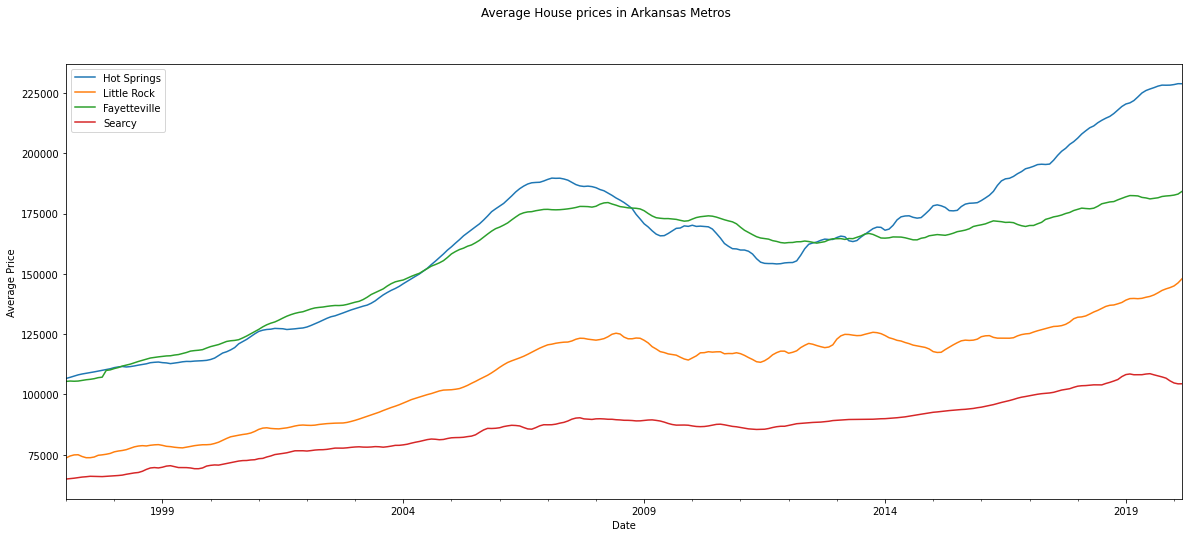

,Metro,Total Return%
0,Fayetteville,114.580000
1,Hot Springs,100.850000
2,Little Rock,74.750000
3,Searcy,60.820000


In [82]:
# time series plots of Avg price over time

fig, ax = plt.subplots()
fig.suptitle('Average House prices in Arkansas Metros')
fig.set_figheight(8)
fig.set_figwidth(20)

# Additional customizations
ax.set_xlabel('Date')
ax.set_ylabel('Average Price')
dfArFinal.groupby('Metro').plot( ax=ax, label='Metro')
plt.legend(metro_areas)
#dfArFinal.plot(ax=ax,label=dfArFinal['Metro'])
plt.show()

# return summary
summary_table = []
for i in range(len(metro_areas)):
  summary_table.append(return_calc(dfArFinal, metro_areas[i])) 

summary_table=pd.DataFrame(zip(metro_areas,summary_table),columns=["Metro",'Total Return%'])
summary_table.sort_values('Total Return%', ascending=False, ignore_index=True).style


In [89]:
# melting the full dataframe to create forecast of median house price per zip code from 2018 (1997-2017) as training set

#print(*df1.columns, sep = "\n")
# region name == zipcode
df1.head()
# dropping columns 
df2 = df1[df1.columns.drop(list(df1.filter(regex='1996-')))]
df2.reset_index(inplace=True)
df2 = df2.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName','State', 'City', 'CountyName'])

mainDateCols = list(df2.filter(regex='-'))
df3 = pd.melt(df2, id_vars=mainDateCols, value_vars='RegionName', value_name='ZipCode' )
df3 = df3.groupby('ZipCode').median()

df3.reset_index(inplace=True)
df4 = pd.melt(df3, id_vars='ZipCode', value_vars=mainDateCols , var_name='Date', value_name='Median_Home_Value')
df5 = pd.pivot_table(data=df4,
    index='Date',
    columns='ZipCode',
   values = 'Median_Home_Value'
    ).reset_index()
df5.head()

ZipCode,Date,10001,10002,10003,10004,10005,10006,10007,10009,1001,10010,10011,10012,10013,10014,10016,10017,10018,10019,1002,10021,10022,10023,10024,10025,10026,10027,10028,10029,10030,10031,10032,10033,10034,10035,10036,10037,10038,10039,10040,...,99568,99572,99574,99577,99587,99603,99605,99610,99611,99615,99623,99631,99635,99639,99643,99645,99652,99654,99663,99664,99669,99672,99674,99676,99683,99686,99688,99701,99705,99709,99712,99714,99762,99801,99824,99827,99833,99835,99901,99929
0,1997-01-31,338388.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164332.0,3108947.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,188034.0,241806.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1997-02-28,344245.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119377.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165563.0,3138019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,188272.0,239372.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1997-03-31,352668.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118792.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,166558.0,3138945.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,187860.0,238648.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1997-04-30,356969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118553.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,166918.0,3112536.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,186622.0,237480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1997-05-31,364187.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118968.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167256.0,3095231.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,186041.0,238533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# put df5 into an arima model

#Testing with zip 10001